In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Loading Datasets

In [2]:
# Loading datas
labels = ['Lagged', 'MA', 'WMA', 'MA-Lagged', 'WMA-Lagged'] # names of each datasets

def load_datasets():
    """
    Excel files for each dataset are read into a 
    dataframe an stored in a dictionary for easy 
    access and use
    """
    datasets = dict()
    for lb in labels:
        new_df = pd.read_excel(f"River-Data-{lb}.xlsx")
        new_df.drop(["Unnamed: 0"], axis=1, inplace=True)
        datasets[lb] = new_df
    
    return datasets

data = load_datasets() # a dataframe for each dataset is stored in a dictionary called data

# Utility Functions

#### Standardising and Unstandardising Values

In [3]:
# Utility Functions
## Functions for standardising and unstandardising values
def standardise_columns(df, cols):
    """
    This function works with dataframes to standardise values
    in multiple columns to the range [0.1, 0.9]
    """
    subset_df = df[cols]
    subset_df = 0.8 * ((subset_df - subset_df.min()) / (subset_df.max() - subset_df.min())) + 0.1
    return subset_df

def unstandardise_columns(df, cols, max_val, min_val):
    """
    This function works with numpy arrays to destandardise values
    in multiple columns
    """
    subset_df = df[cols]
    subset_df = ((subset_df - subset_df.min()) / 0.8) * (max_val - min_val) + min_val
    return subset_df

def standardise_value(x, max_val, min_val):
    """
    This function works with numpy arrays to standardise values
    in multiple arrays to the range [0.1, 0.9]
    """
    return 0.8 * ((x - min_val)) / (max_val - min_val) + 0.1

def unstandardise_value(x, max_val, min_val):
    """
    This function works with numpy arrays to destandardise values
    in multiple arrays
    """
    return ((x - 0.1) / 0.8) * (max_val - min_val) + min_val

#### Plotting

In [4]:
## Plotting functions
def plot_correlation_matrix(corr_data, title, figsize=(16,6), mask=False):
    """
    Utility function for plotting a correlation heatmap of a given feature set
    """
    if mask:
        mask = np.triu(np.ones_like(corr_data, dtype=bool))
    plt.figure(figsize=figsize, dpi=500)
    heatmap = sns.heatmap(corr_data, vmin=-1, vmax=1, annot=True, mask=mask)
    heatmap.set_title(title)
    plt.show()

def plot_predictions(preds_df, standardised=False):
    """
    Utiltity function for plotting model predictions against actual value
    """
    preds_col = "Predicted Values"
    vals_col = "Actual Values"
    if standardised:
        preds_col += " (Standardised)"
        vals_col += " (Standardised)"
    
    line_plt = px.line(preds_df, y=vals_col)
    scatter_plt = px.scatter(preds_df, y=preds_col, color_discrete_sequence=["#ff0000"])
    
    go.Figure(line_plt.data + scatter_plt.data, layout={"title": "Actual vs Predicted Values"}).show()

# ANN Class

In [5]:
# Basic ANN class for MLP models
class BasicAnn:
    def __init__(self, layers, max_st_val, min_st_val, activ_func="sigmoid"):
        self.layers = layers
        self.num_layers = len(layers)
        self.max_val = max_st_val
        self.min_val = min_st_val
        self.activ_func = activ_func
        
        weight_shapes = [(layers[i-1],layers[i]) for i in range(1, len(layers))]
        self.weights = {
            f"W{i+1}": np.random.standard_normal(s)/s[0]**0.5 
            for i, s in enumerate(weight_shapes) 
        } # weights are stored as matrices that are implemented as 2D numpy arrays
        self.biases = {
            f"B{i+1}": np.random.randn(l,1)/l**0.5 
            for i, l in enumerate(layers[1:])
        } # biases are also stored as matrices that are implemented as 2D numpy arrays
    
    def activation(self, x):
        """
        Function to return value with the selected activation
        """
        if self.activ_func == "sigmoid":
            return 1/(1+np.exp(-x))
        elif self.activ_func == "tanh":
            return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        elif self.activ_func == "relu":
            return x * (x > 0)
        elif self.activ_func == "linear":
            return x
    
    def activation_deriv(self, a):
        """
        Function to return value with the derivative of the selected activation
        """
        if self.activ_func == "sigmoid":
            return a * (1 - a)
        elif self.activ_func == "tanh":
            return 1 - a**2
        elif self.activ_func == "relu":
            return 1 * (a > 0)
        elif self.activ_func == "linear":
            return np.ones(a.shape)
    
    def train(self, features, targets, epochs=1000, learning_rate=0.1, val_set=None):
        """
        Function will train the model using the standard backpropogation algorithm
        and return a dataframe storing various error metrics for the model on the
        training set and, possibly, a validation set if that is given
        """
        results = pd.DataFrame()
        real_targets = unstandardise_value(targets, self.max_val, self.min_val)
        num_targets = len(targets)
        
        for _ in range(epochs):
            # Forward pass
            activations = self.forward_pass(features)

            # Error calculation
            output_layer = activations[f"A{self.num_layers - 1}"]
            real_preds = unstandardise_value(output_layer, self.max_val, self.min_val)
            error_data = { # storing error metrics for both standardised and unstandardised data
                "mse": mean_squared_error(real_targets, real_preds),
                "rmse": mean_squared_error(real_targets, real_preds, squared=False),
                "mae": mean_absolute_error(real_targets, real_preds),
                "r_sqr": r2_score(real_targets, real_preds),
                "st_mse": mean_squared_error(targets, output_layer),
                "st_rmse": mean_squared_error(targets, output_layer, squared=False),
                "st_mae": mean_absolute_error(targets, output_layer),
                "st_r_sqr": r2_score(targets, output_layer)
            }
            
            if val_set: 
                # if there is a validation set the prediction error of the model
                # on the validation set will be stored
                r, err = self.predict(val_set[0].to_numpy(), val_set[1].to_numpy())
                error_data.update({f"val_{col}": err[col][0] for col in err.columns})
            
            results = results.append(error_data, ignore_index=True)
            
            # Backward pass (backpropagation algorithm)
            deltas = self.compute_deltas(activations, targets, output_layer)
            self.update_weights(deltas, activations, features, num_targets, learning_rate)
        
        return results
    
    def predict(self, test_inputs, st_actual_outputs, actual_outputs=None):
        """
        Runs a forward pass of the network with the newly configured weights
        and biases and returns a dataframe comparing the predicted values
        to actual values as well as a dataframe with various error metrics
        """
        # Forward pass
        activations = self.forward_pass(test_inputs)
        st_preds = activations[f"A{self.num_layers - 1}"]
        
        # Comparing predicted values with actual values
        if actual_outputs is None:
            actual_outputs = unstandardise_value(st_actual_outputs, self.max_val, self.min_val)
        
        preds = unstandardise_value(st_preds, self.max_val, self.min_val)
        
        results = pd.DataFrame(
            data={
                "Actual Values": actual_outputs.flatten(), 
                "Predicted Values": preds.flatten(),
                "Actual Values (Standardised)": st_actual_outputs.flatten(),
                "Predicted Values (Standardised)": st_preds.flatten(),
            }
        )
        
        # Error calculation
        results["Absolute Error"] = abs(results["Actual Values"] - results["Predicted Values"])
        st_absolute_err = abs(results["Actual Values (Standardised)"] - results["Predicted Values (Standardised)"])
        results["Absolute Error (Standardised Values)"] = st_absolute_err
        
        error_metrics = pd.DataFrame(data={
            "mse": [mean_squared_error(actual_outputs, preds)],
            "rmse": [mean_squared_error(actual_outputs, preds, squared=False)],
            "mae": [mean_absolute_error(actual_outputs, preds)],
            "r_sqr": [r2_score(actual_outputs, preds)],
            "st_mse": [mean_squared_error(st_actual_outputs, st_preds)],
            "st_rmse": [mean_squared_error(st_actual_outputs, st_preds, squared=False)],
            "st_mae": [mean_absolute_error(st_actual_outputs, st_preds)],
            "st_r_sqr": [r2_score(st_actual_outputs, st_preds)]
        })
        
        return results, error_metrics
    
    def forward_pass(self, features):
        """
        Runs a forward pass of neural network through repeated
        multiplication of weights and bias matrices. Returns
        list of each activation layer including the output layer.
        """
        activation = self.activation(np.dot(features, self.weights["W1"]) + self.biases["B1"].T)
        activations = {"A1": activation}
        for i in range(2, self.num_layers):
            activation = self.activation(np.dot(activation, self.weights[f"W{i}"]) + self.biases[f"B{i}"].T)
            activations[f"A{i}"] = activation
        
        return activations
    
    def compute_deltas(self, activations, targets, output_layer):
        """
        Computes errors between layers for backprogation.
        Returns a dictionary of lists which contain the errors
        for each node in each layer.
        """
        output_err = targets - output_layer
        output_delta = output_err * self.activation_deriv(output_layer)
        deltas = {"dw1": output_delta}

        for i in range(self.num_layers - 1, 1, -1):
            dw = deltas[f"dw{self.num_layers - i}"]
            act = activations[f"A{i-1}"]
            w = self.weights[f"W{i}"]
            deltas[f"dw{self.num_layers - i + 1}"] = np.dot(dw, w.T) * self.activation_deriv(act)
        
        return deltas
    
    def update_weights(self, deltas, activations, features, num_targets, l_rate):
        """
        Updates weights and biases according to given errors, activations
        and the chosen learning rate
        """
        delta = deltas[f"dw{self.num_layers - 1}"]
        self.weights["W1"] += l_rate * (np.dot(features.T, delta)) / num_targets
        self.biases["B1"] += l_rate * (np.dot(delta.T, np.ones((num_targets, 1)))) / num_targets

        for i in range(2, self.num_layers):
            act = activations[f"A{i-1}"]
            dw = deltas[f"dw{self.num_layers - i}"]
            self.weights[f"W{i}"] += l_rate * (np.dot(act.T, dw)) / num_targets
            self.biases[f"B{i}"] += l_rate * np.dot(dw.T, np.ones((num_targets, 1))) / num_targets      

#### Build, Train and Test ANN Model

In [6]:
def build_train_test(feature_set, feature_cols, target_cols, layers=("auto", 1), activ_func="linear", epochs=1000, l_rate=0.1):
    """
    Function to build, train and test MLP models
    """
    # Splitting and standardising datasets to create standardised and unstandardised
    # training, validation and testing sets.
    train_val_set, test_set = train_test_split(feature_set, test_size=0.2)
    st_train_val_set = standardise_columns(train_val_set, train_val_set.columns)
    st_test_set = standardise_columns(test_set, test_set.columns)
    
    # Preparing features and targets for training and testing
    features = st_train_val_set[feature_cols]
    targets = st_train_val_set[target_cols]
    
    X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.25)
    X_test, y_test = st_test_set[feature_cols], st_test_set[target_cols]
    
    # Getting standardisation values for targets
    min_val = train_val_set[target_cols].min()[0]
    max_val = train_val_set[target_cols].max()[0]
        
    # Building model
    if layers[0] == "auto":
        # if the size of the input layer is not specified 
        # then it will be set to the number of predictors
        layers = (len(feature_cols),) + layers[1:]
    
    ann = BasicAnn(layers, max_val, min_val, activ_func)
    
    # Training model
    training_results = ann.train(
        X_train.to_numpy(), 
        y_train.to_numpy(), 
        val_set=(X_val, y_val), # training with a validation set
        epochs=epochs,
        learning_rate=l_rate
    )
    
    # Predicting model
    prediction_results = ann.predict(
        X_test.to_numpy(), 
        y_test.to_numpy(), 
        actual_outputs=test_set[target_cols].to_numpy()
    )
    
    predictions, error_metrics = prediction_results[0], prediction_results[1]
    
    return {
        "training_results": training_results,
        "final_test_results": predictions,
        "error_metrics": error_metrics,
        "model": ann
    }

# Selecting Features/Predictors

#### Building Feature Sets

In [7]:
# Function for building custom feature and target sets
def build_feature_set(*datasets):
    assert len(datasets) > 0, "No data sets entered"
    datasets = list(datasets)
    min_rows = min(d.shape[0] for d in datasets)
    
    for i, ds in enumerate(datasets):
        datasets[i] = ds.truncate(before=ds.shape[0]-min_rows).reset_index()
        datasets[i].drop(["index"], axis=1, inplace=True)
        
    merged_df = datasets[0].iloc[:, :2]
    for ds in datasets:
        merged_df = pd.concat([merged_df, ds.iloc[:, 2:]], axis=1)
    
    merged_cols = list(merged_df.columns)
    selected_cols = []
    
    for i in range(0, len(merged_cols), 2):
        format_str = f"{i+1}) {merged_cols[i]}"
        if i != len(merged_cols) - 1:
            second_part = f"{i+2}) {merged_cols[i+1]}"
            num_spaces = 50 - len(format_str)
            format_str += num_spaces*" " + second_part
        print(format_str)
    
    selected_indices = input("\nSelect columns: ")
    for index in selected_indices.split(","):
        if "-" in index:
            first_i, second_i = index.split("-")
            selected_cols += merged_cols[int(first_i) - 1: int(second_i)]
        else:
            selected_cols.append(merged_cols[int(index) - 1])
    
    return merged_df[selected_cols]

1) Date                                           2) Skelton MDF (Cumecs)
3) Crakehill MDF (WMA3)                           4) Skip Bridge MDF (WMA3)
5) Westwick MDF (WMA3)                            6) Skelton MDF (WMA3)
7) Crakehill MDF (WMA4)                           8) Skip Bridge MDF (WMA4)
9) Westwick MDF (WMA4)                            10) Skelton MDF (WMA4)
11) Crakehill MDF (WMA5)                          12) Skip Bridge MDF (WMA5)
13) Westwick MDF (WMA5)                           14) Skelton MDF (WMA5)
15) Crakehill MDF (WMA6)                          16) Skip Bridge MDF (WMA6)
17) Westwick MDF (WMA6)                           18) Skelton MDF (WMA6)
19) Crakehill MDF (WMA7)                          20) Skip Bridge MDF (WMA7)
21) Westwick MDF (WMA7)                           22) Skelton MDF (WMA7)
23) Arkengarthdale DRT (WMA3)                     24) East Cowton DRT (WMA3)
25) Malham Tarn DRT (WMA3)                        26) Snaizeholme DRT (WMA3)
27) Arkengarthdale DRT (W

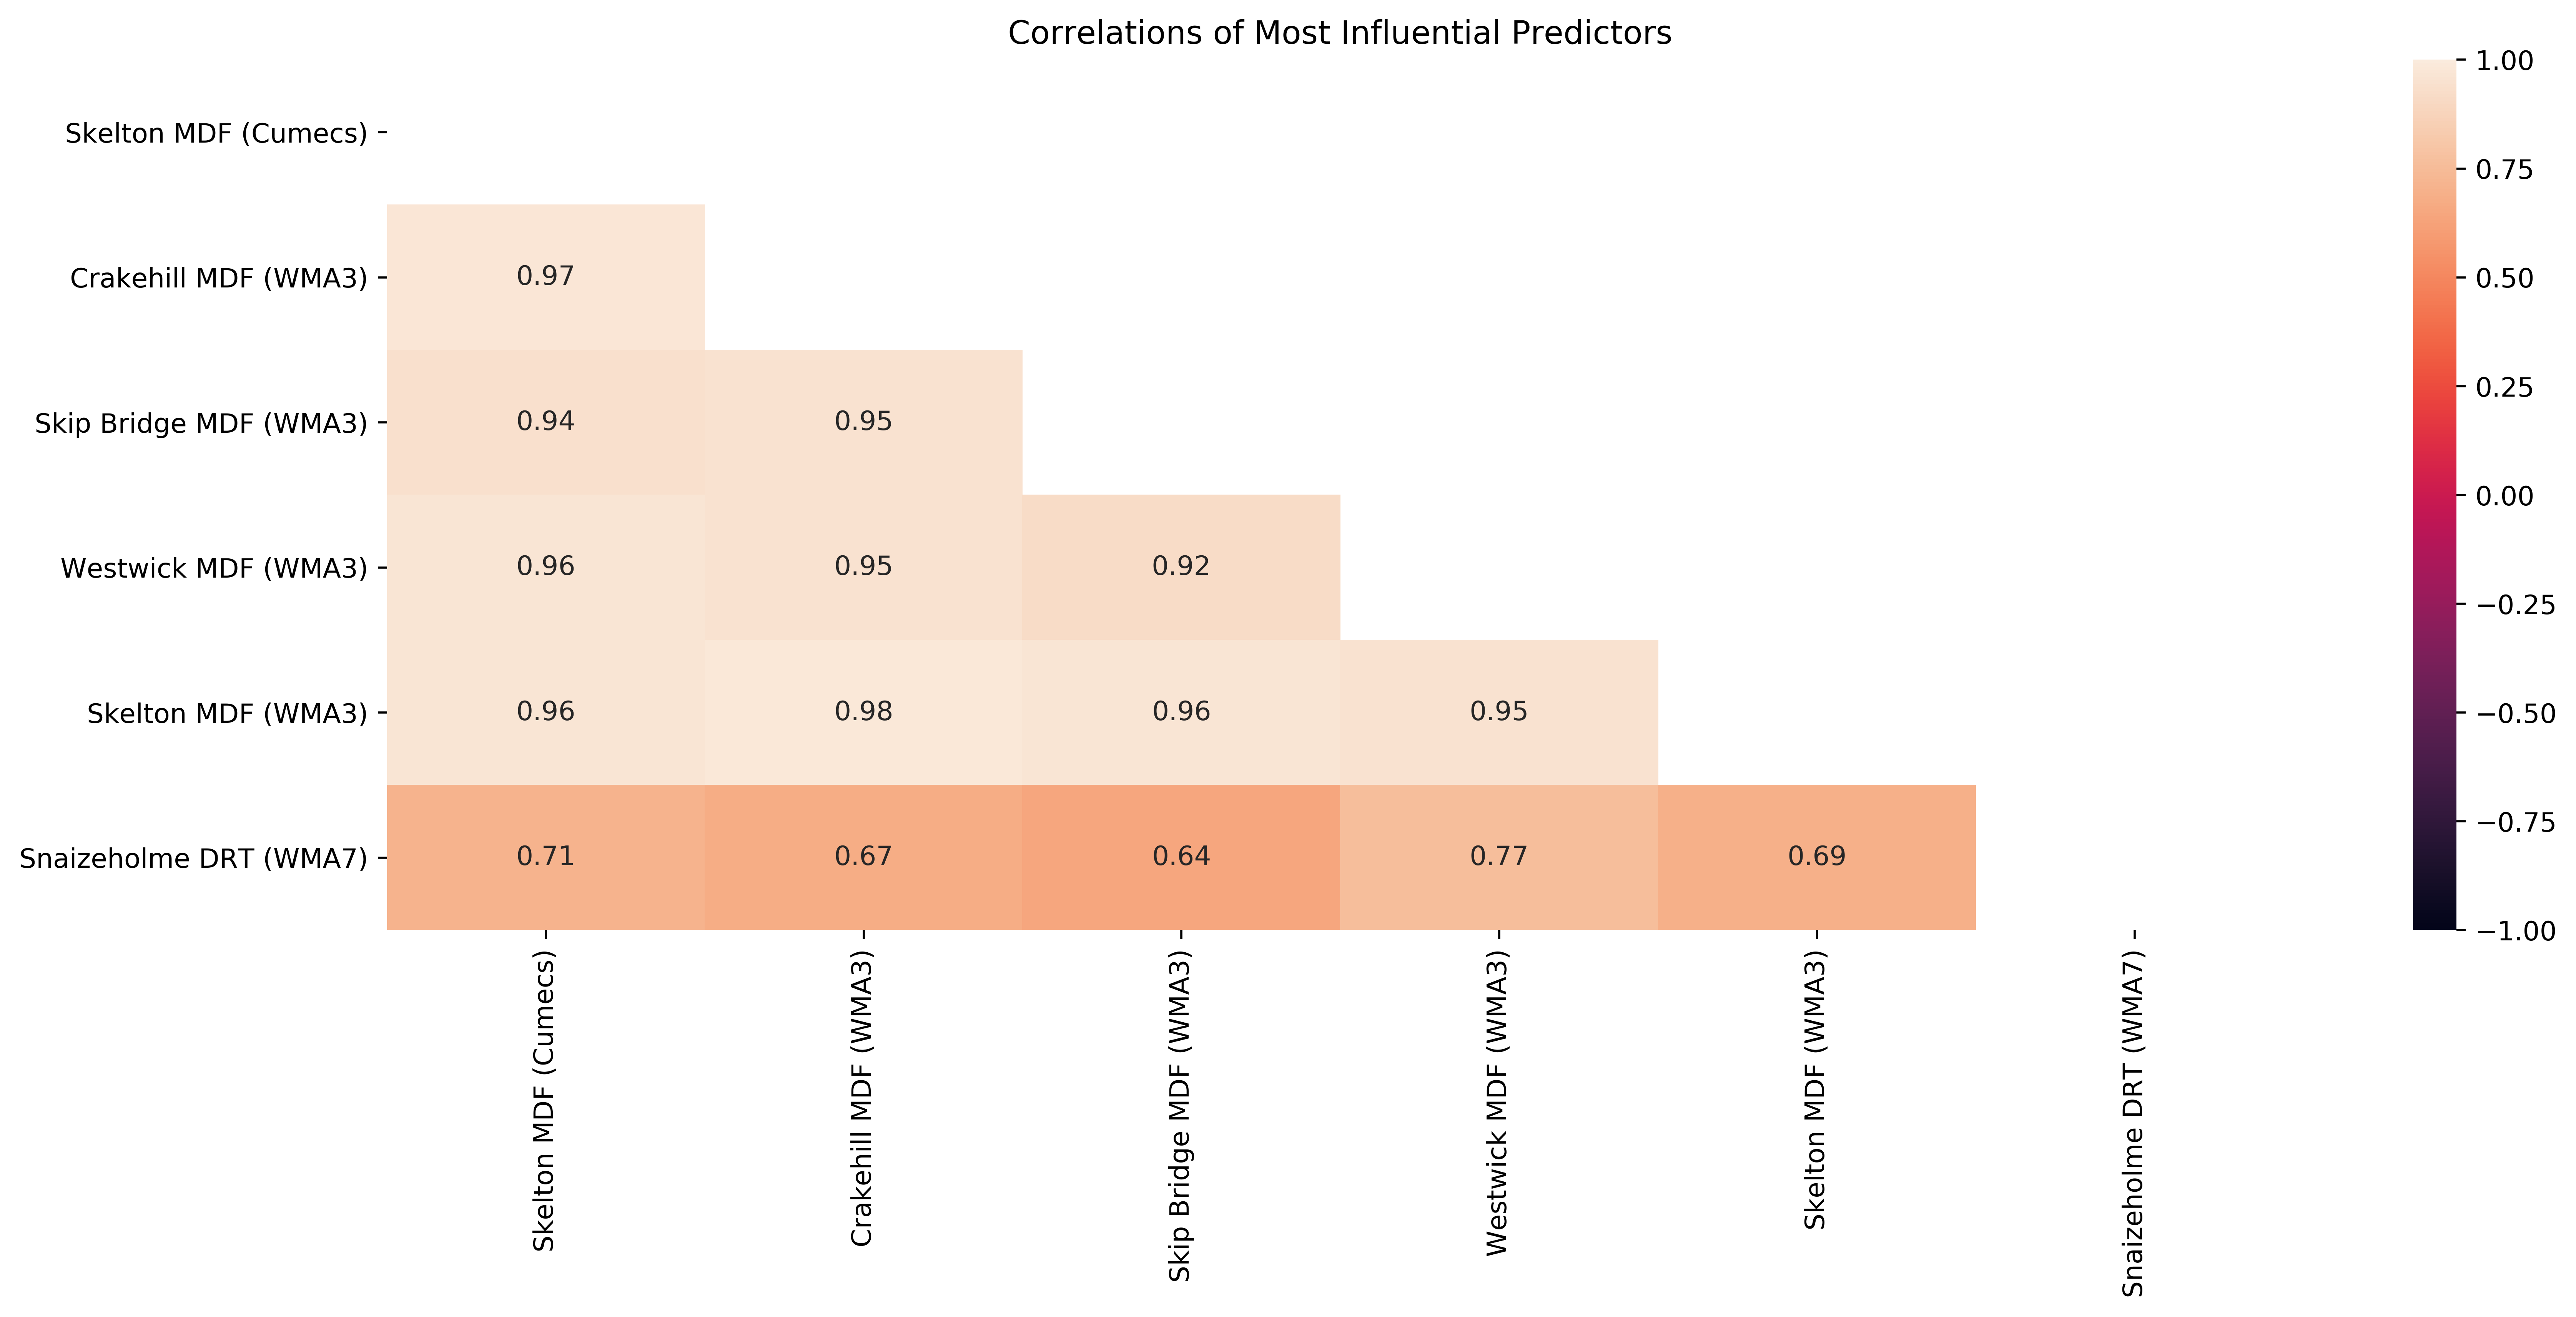

In [8]:
# 2,3-6,42
fs = build_feature_set(data['WMA'])
plot_correlation_matrix(fs.corr(), "Correlations of Most Influential Predictors", mask=True)

# Training and Network Selection

#### Epochs

In [9]:
target_cols = [fs.columns[0]]
feature_cols = list(fs.columns[1:])

epoch_tests = dict()
for i in range(1, 11):
    epoch_tests[f"Test-{i}"] = build_train_test(
        fs, 
        feature_cols, 
        target_cols, 
        layers=("auto", 1), 
        activ_func="linear",
        epochs=i*500
    )

- rmse -> root mean square error
- mae -> mean absolute error
- mse -> mean squared error
- r_sqr -> R-Squared (Coefficient of Determination)

- val_* -> error metric on validation set
- st_* -> error metric on unstandardised values

Model trained with 500 epochs
----------------------------------------------------------------------------------------------------
Final Training results
mae        20.499129
mse      1096.040247
r_sqr       0.661040
rmse       33.106499
Name: 499, dtype: float64
----------------------------------------------------------------------------------------------------
Final Validation results
val_mae       18.866270
val_mse      954.844934
val_r_sqr      0.685358
val_rmse      30.900565
Name: 499, dtype: float64
----------------------------------------------------------------------------------------------------
Test Set Results
mse         2311.870841
rmse          48.081918
mae           26.628531
r_sqr          0.160937
st_mse         0.004661
st_rmse        0.068273
st_mae         0.038481
st_r_sqr       0.737755
Name: 0, dtype: float64



Model trained with 1000 epochs
----------------------------------------------------------------------------------------------------
Final Training resu

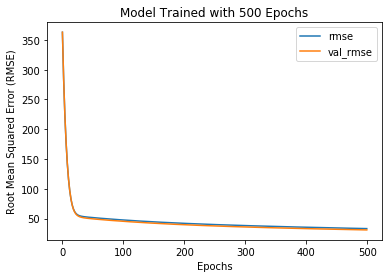

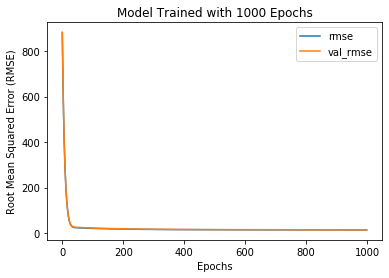

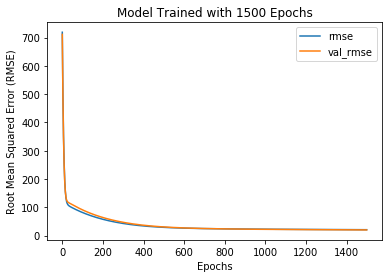

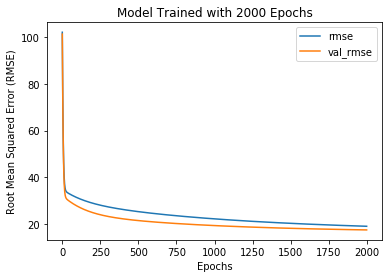

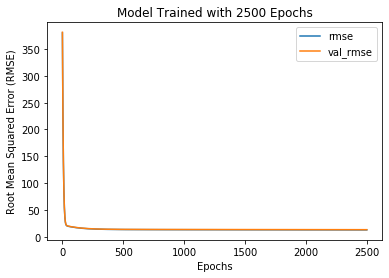

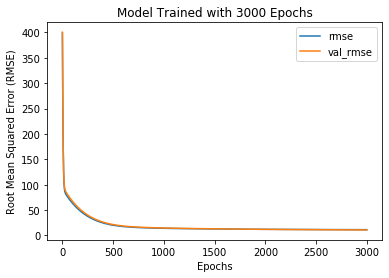

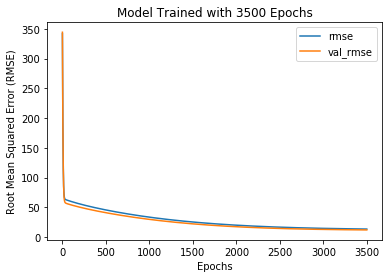

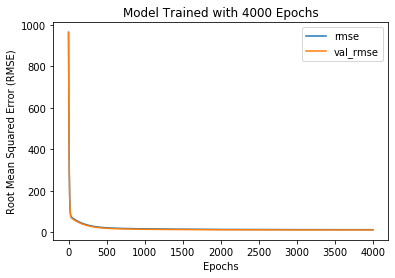

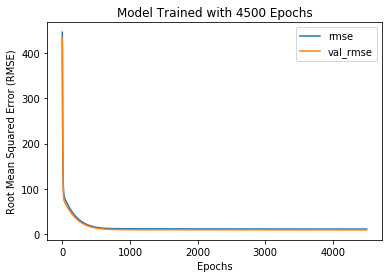

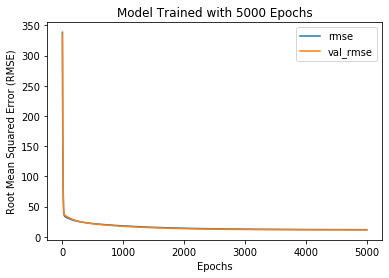

In [10]:
# Testing number of epochs for training; between 800 and 1200 seems to be ideal
for i in range(1, 11):
    print(f"Model trained with {i*500} epochs", end=f"\n{'-'*100}\n")
    
    print("Final Training results")
    print(epoch_tests[f"Test-{i}"]["training_results"].iloc[-1, :4], end=f"\n{'-'*100}\n")
    
    print("Final Validation results")
    print(epoch_tests[f"Test-{i}"]["training_results"].iloc[-1, 8:12], end=f"\n{'-'*100}\n")
    
    print("Test Set Results")
    print(epoch_tests[f"Test-{i}"]["error_metrics"].iloc[0], end=f"\n{'='*100}\n\n\n\n")
    
    ax = epoch_tests[f"Test-{i}"]["training_results"].plot(
        y=["rmse", "val_rmse"], title=f"Model Trained with {i*500} Epochs",
    )
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Root Mean Squared Error (RMSE)")

- Models seem to overfit after about 800 to 1200 epochs
- Suitable number for training is around 1000

#### Learning Rate

In [11]:
l_rate_tests = dict()
for i in range(1, 11):
    l_rate_tests[f"Test-{i}"] = build_train_test(
        fs, 
        feature_cols, 
        target_cols, 
        layers=("auto", 1), 
        activ_func="linear",
        epochs=1000,
        l_rate=0.1*i
    )

Model Trained with Learning Rate of 0.1
----------------------------------------------------------------------------------------------------
Final Training results
mae        9.726736
mse      268.105614
r_sqr      0.921780
rmse      16.373931
Name: 999, dtype: float64
----------------------------------------------------------------------------------------------------
Final Validation results
val_mae        9.844338
val_mse      309.177240
val_r_sqr      0.893526
val_rmse      17.583437
Name: 999, dtype: float64
----------------------------------------------------------------------------------------------------
Test Set Results
mse         3018.474167
rmse          54.940642
mae           36.964490
r_sqr         -0.315723
st_mse         0.003342
st_rmse        0.057812
st_mae         0.037198
st_r_sqr       0.788729
Name: 0, dtype: float64



Model Trained with Learning Rate of 0.2
----------------------------------------------------------------------------------------------------
Fina

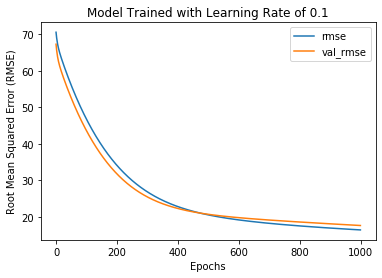

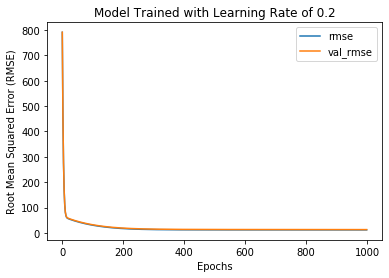

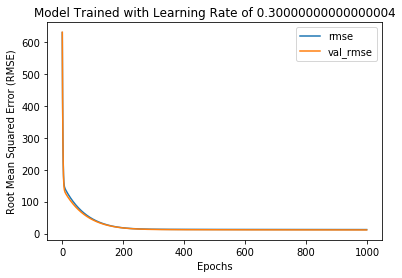

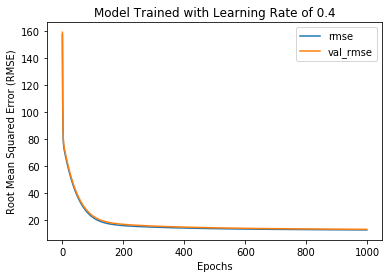

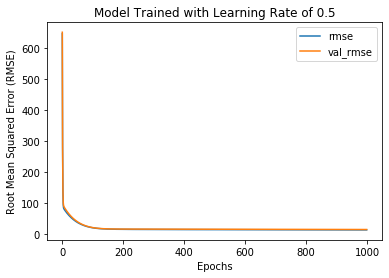

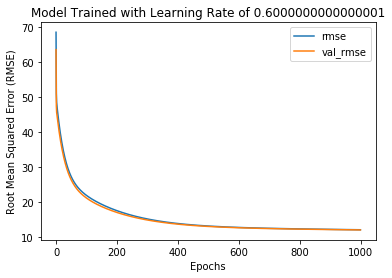

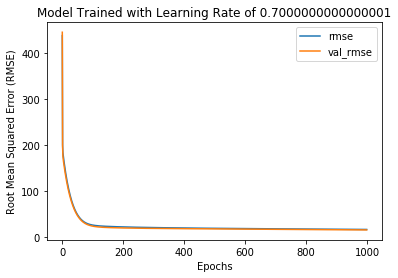

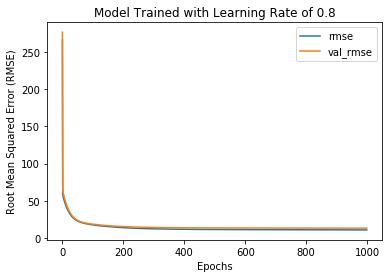

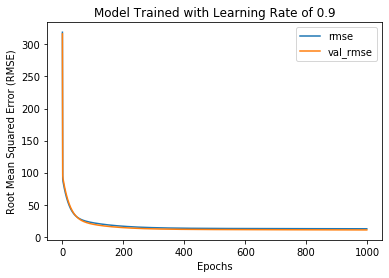

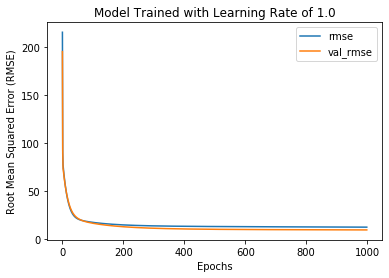

In [12]:
for i in range(1,11):
    print(f"Model Trained with Learning Rate of {0.1*i}", end=f"\n{'-'*100}\n")
          
    print("Final Training results")
    print(l_rate_tests[f"Test-{i}"]["training_results"].iloc[-1, :4], end=f"\n{'-'*100}\n")
    
    print("Final Validation results")
    print(l_rate_tests[f"Test-{i}"]["training_results"].iloc[-1, 8:12], end=f"\n{'-'*100}\n")
    
    print("Test Set Results")
    print(l_rate_tests[f"Test-{i}"]["error_metrics"].iloc[0], end=f"\n{'='*100}\n\n\n\n")
    
    ax = l_rate_tests[f"Test-{i}"]["training_results"].plot(
        y=["rmse", "val_rmse"], title=f"Model Trained with Learning Rate of {i*0.1}",
    )
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Root Mean Squared Error (RMSE)")

- learning rate of 0.3 appears to offer most consistent resuls between training, validation and testing sets

#### Activation Functions

In [13]:
activ_tests = dict()
activations = ("sigmoid", "tanh", "relu", "linear")

for func in activations:
    activ_tests[func] = build_train_test(
        fs, 
        feature_cols, 
        target_cols, 
        layers=("auto", 1), 
        activ_func=func,
        epochs=1000,
        l_rate=0.1
    )

Model Trained with Sigmoid Activation Function
----------------------------------------------------------------------------------------------------
Final Training Results
mae        36.919182
mse      2331.934397
r_sqr       0.173079
rmse       48.290107
Name: 999, dtype: float64
----------------------------------------------------------------------------------------------------
Final Validation Results
val_mae        39.417434
val_mse      2845.481178
val_r_sqr       0.182565
val_rmse       53.343052
Name: 999, dtype: float64
----------------------------------------------------------------------------------------------------
Test Set Results
mse         2746.415033
rmse          52.406250
mae           37.247438
r_sqr          0.226624
st_mse         0.009423
st_rmse        0.097070
st_mae         0.076474
st_r_sqr       0.182605
Name: 0, dtype: float64



Model Trained with Tanh Activation Function
--------------------------------------------------------------------------------------

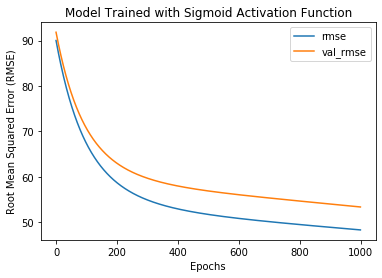

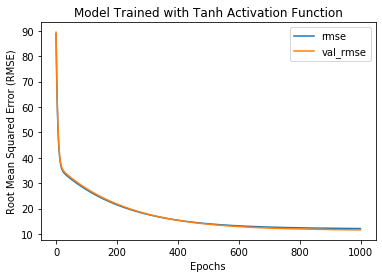

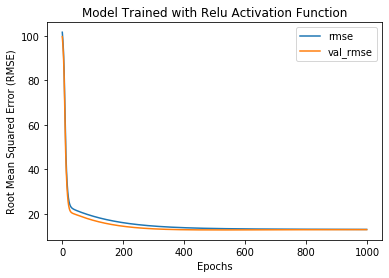

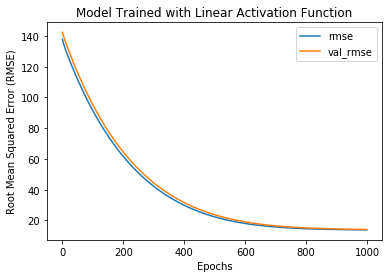

In [14]:
for a in activations:
    print(f"Model Trained with {a.capitalize()} Activation Function", end=f"\n{'-'*100}\n")
    
    print("Final Training Results")
    print(activ_tests[a]["training_results"].iloc[-1, :4], end=f"\n{'-'*100}\n")
    
    print("Final Validation Results")
    print(activ_tests[a]["training_results"].iloc[-1, 8:12], end=f"\n{'-'*100}\n")
    
    print("Test Set Results")
    print(activ_tests[a]["error_metrics"].iloc[0], end=f"\n{'='*100}\n\n\n\n")
    
    ax = activ_tests[a]["training_results"].plot(
        y=["rmse", "val_rmse"], title=f"Model Trained with {a.capitalize()} Activation Function",
    )
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Root Mean Squared Error (RMSE)")

- tanh is quite clearly the best performing activation function

#### Hidden Layers

In [15]:
layer_tests = dict()
for i in range(1, 11):
    layer_tests[f"Test-{i}"] = build_train_test(
        fs, 
        feature_cols, 
        target_cols, 
        layers=("auto", i, 1), 
        activ_func="tanh",
        epochs=1000,
        l_rate=0.1
    )

Model trained with Single Hidden Layer of Size 1
----------------------------------------------------------------------------------------------------
Final Training Results
mae        9.969888
mse      282.456184
r_sqr      0.911033
rmse      16.806433
Name: 999, dtype: float64
----------------------------------------------------------------------------------------------------
Final Validation Results
val_mae        9.290617
val_mse      227.837865
val_r_sqr      0.929973
val_rmse      15.094299
Name: 999, dtype: float64
----------------------------------------------------------------------------------------------------
Test Set Results
mse         1027.611385
rmse          32.056378
mae           23.286580
r_sqr          0.619731
st_mse         0.002052
st_rmse        0.045301
st_mae         0.024942
st_r_sqr       0.908920
Name: 0, dtype: float64



Model trained with Single Hidden Layer of Size 2
---------------------------------------------------------------------------------------

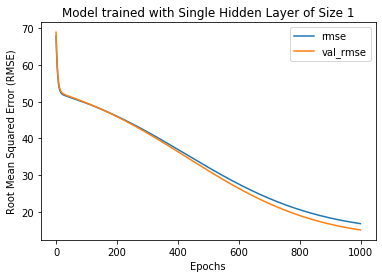

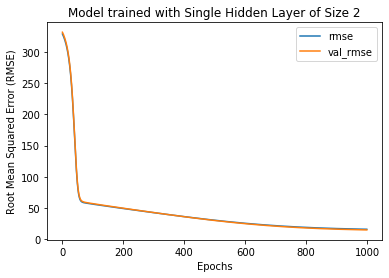

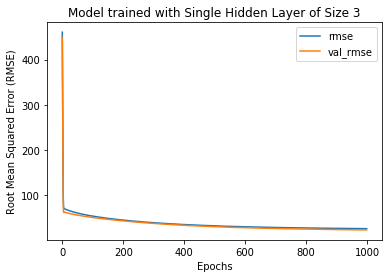

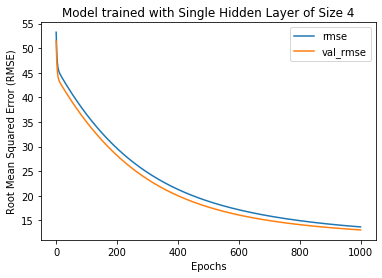

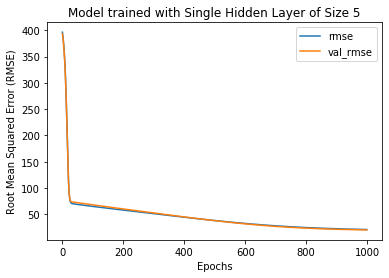

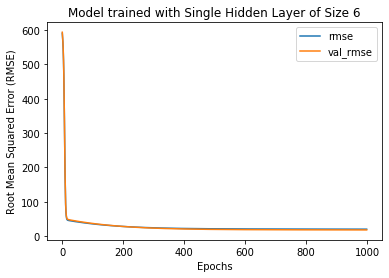

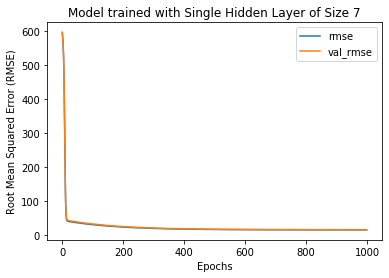

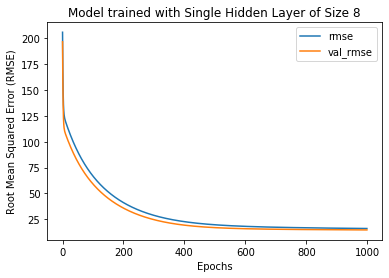

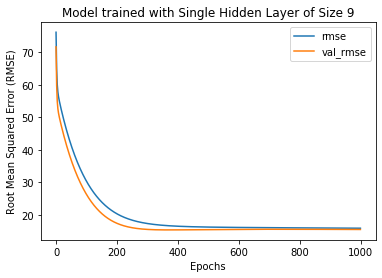

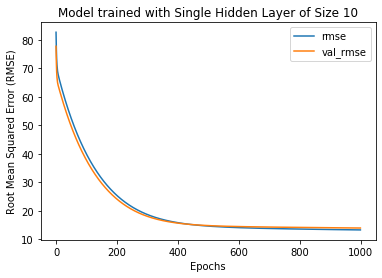

In [16]:
for i in range(1,11):
    print(f"Model trained with Single Hidden Layer of Size {i}", end=f"\n{'-'*100}\n")
    
    print("Final Training Results")
    print(layer_tests[f"Test-{i}"]["training_results"].iloc[-1, :4], end=f"\n{'-'*100}\n")
    
    print("Final Validation Results")
    print(layer_tests[f"Test-{i}"]["training_results"].iloc[-1, 8:12], end=f"\n{'-'*100}\n")
    
    print("Test Set Results")
    print(layer_tests[f"Test-{i}"]["error_metrics"].iloc[0], end=f"\n{'='*100}\n\n\n\n")
    
    ax = layer_tests[f"Test-{i}"]["training_results"].plot(
        y=["rmse", "val_rmse"], title=f"Model trained with Single Hidden Layer of Size {i}",
    )
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Root Mean Squared Error (RMSE)")
    

In [17]:
layer_tests_2 = dict()
for i in range(1, 11):
    layer_tests_2[f"Test-{i}"] = build_train_test(
        fs, 
        feature_cols, 
        target_cols, 
        layers=("auto", 9, i, 1), 
        activ_func="tanh",
        epochs=1000,
        l_rate=0.1
    )

Model Trained with Hidden Layer Configuration (9, 1)
----------------------------------------------------------------------------------------------------
Final Training Results
mae        39.911623
mse      3018.762782
r_sqr       0.007139
rmse       54.943269
Name: 999, dtype: float64
----------------------------------------------------------------------------------------------------
Final Validation Results
val_mae        42.308685
val_mse      4103.713699
val_r_sqr       0.006976
val_rmse       64.060235
Name: 999, dtype: float64
----------------------------------------------------------------------------------------------------
Test Set Results
mse         2186.571752
rmse          46.760793
mae           35.732413
r_sqr          0.003111
st_mse         0.016933
st_rmse        0.130126
st_mae         0.082543
st_r_sqr      -0.015506
Name: 0, dtype: float64



Model Trained with Hidden Layer Configuration (9, 2)
-----------------------------------------------------------------------

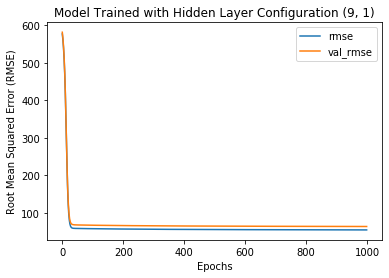

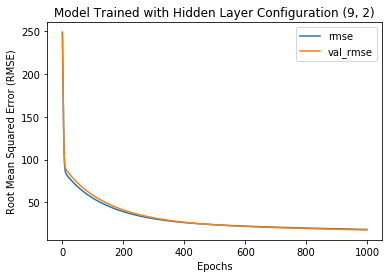

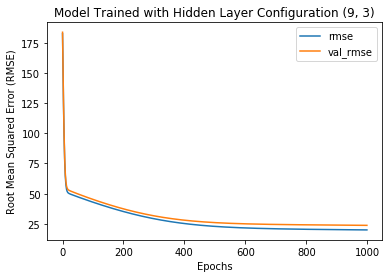

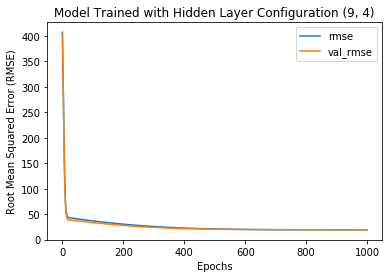

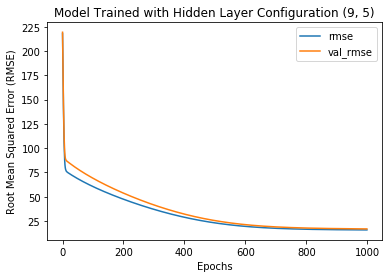

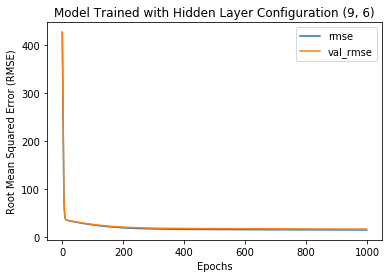

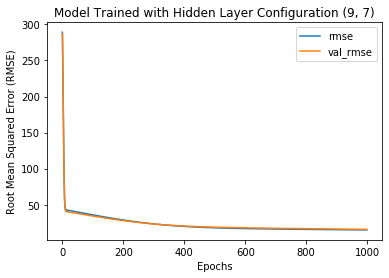

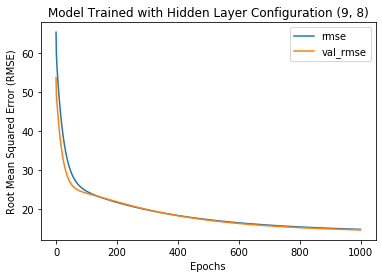

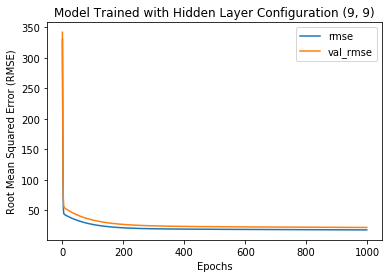

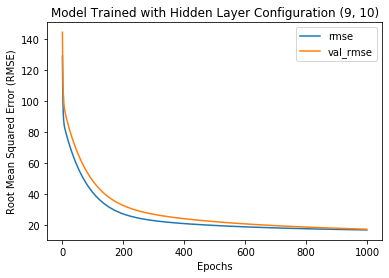

In [18]:
for i in range(1,11):
    print(f"Model Trained with Hidden Layer Configuration (9, {i})", end=f"\n{'-'*100}\n")
    
    print("Final Training Results")
    print(layer_tests_2[f"Test-{i}"]["training_results"].iloc[-1, :4], end=f"\n{'-'*100}\n")
    
    print("Final Validation Results")
    print(layer_tests_2[f"Test-{i}"]["training_results"].iloc[-1, 8:12], end=f"\n{'-'*100}\n")
    
    print("Test Set Results")
    print(layer_tests_2[f"Test-{i}"]["error_metrics"].iloc[0], end=f"\n{'='*100}\n\n\n\n")
    
    ax = layer_tests_2[f"Test-{i}"]["training_results"].plot(
        y=["rmse", "val_rmse"], title=f"Model Trained with Hidden Layer Configuration (9, {i})",
    )
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Root Mean Squared Error (RMSE)")

In [19]:
layer_tests_3 = dict()
for i in range(1, 11):
    layer_tests_3[f"Test-{i}"] = build_train_test(
        fs, 
        feature_cols, 
        target_cols, 
        layers=("auto", i, 9, 1), 
        activ_func="tanh",
        epochs=1000,
        l_rate=0.1
    )

Model Trained with Hidden Layer Configuration (1, 9)
----------------------------------------------------------------------------------------------------
Final Training Results
mae        40.454871
mse      3155.758419
r_sqr       0.010587
rmse       56.176137
Name: 999, dtype: float64
----------------------------------------------------------------------------------------------------
Final Validation Results
val_mae        37.360283
val_mse      2704.510387
val_r_sqr       0.011082
val_rmse       52.004907
Name: 999, dtype: float64
----------------------------------------------------------------------------------------------------
Test Set Results
mse         3147.137222
rmse          56.099351
mae           38.888805
r_sqr          0.012500
st_mse         0.010781
st_rmse        0.103832
st_mae         0.080511
st_r_sqr      -0.039762
Name: 0, dtype: float64



Model Trained with Hidden Layer Configuration (2, 9)
-----------------------------------------------------------------------

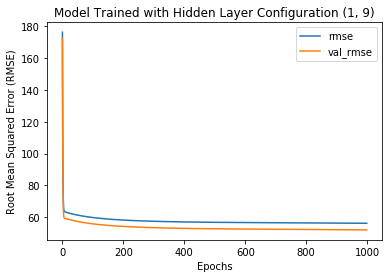

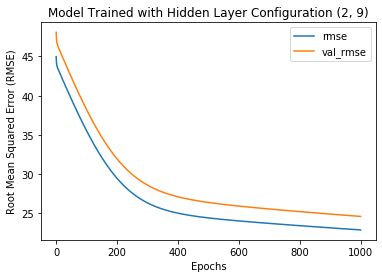

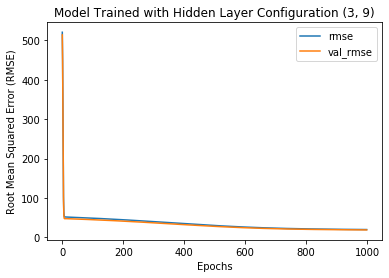

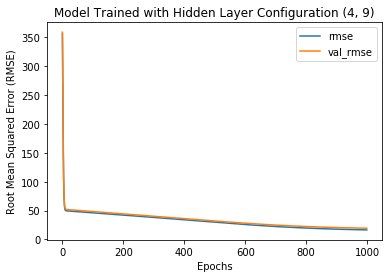

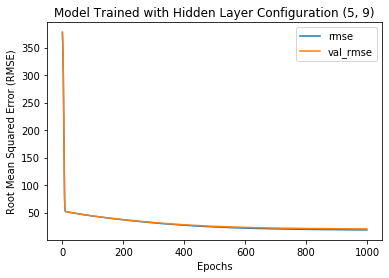

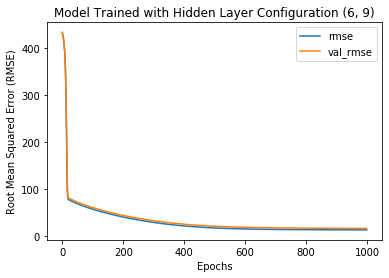

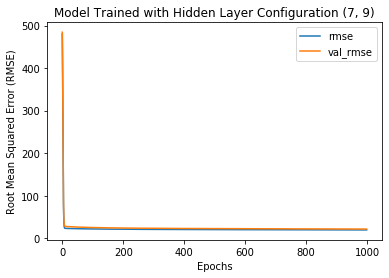

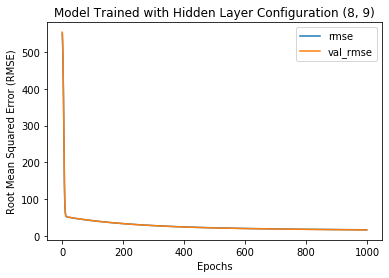

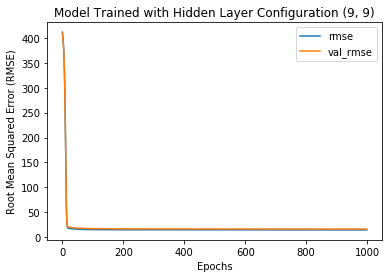

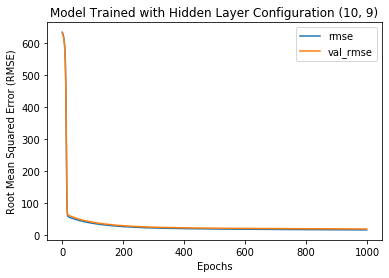

In [20]:
for i in range(1,11):
    print(f"Model Trained with Hidden Layer Configuration ({i}, 9)", end=f"\n{'-'*100}\n")
    
    print("Final Training Results")
    print(layer_tests_3[f"Test-{i}"]["training_results"].iloc[-1, :4], end=f"\n{'-'*100}\n")
    
    print("Final Validation Results")
    print(layer_tests_3[f"Test-{i}"]["training_results"].iloc[-1, 8:12], end=f"\n{'-'*100}\n")
    
    print("Test Set Results")
    print(layer_tests_3[f"Test-{i}"]["error_metrics"].iloc[0], end=f"\n{'='*100}\n\n\n\n")
    
    ax = layer_tests_3[f"Test-{i}"]["training_results"].plot(
        y=["rmse", "val_rmse"], title=f"Model Trained with Hidden Layer Configuration ({i}, 9)",
    )
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Root Mean Squared Error (RMSE)")

# Final Model

In [35]:
final_model = build_train_test(
        fs, 
        feature_cols, 
        target_cols, 
        layers=("auto", 6, 1), 
        activ_func="tanh",
        epochs=800,
        l_rate=0.1
    )

Final Model
----------------------------------------------------------------------------------------------------
Final Training Results
mae        8.223976
mse      226.856201
r_sqr      0.924825
rmse      15.061746
Name: 799, dtype: float64
----------------------------------------------------------------------------------------------------
Final Validation Results
val_mae        7.216636
val_mse      187.389107
val_r_sqr      0.943232
val_rmse      13.689014
Name: 799, dtype: float64
----------------------------------------------------------------------------------------------------
Test Set Results
mse         204.960242
rmse         14.316433
mae           8.348850
r_sqr         0.934637
st_mse        0.001470
st_rmse       0.038338
st_mae        0.018020
st_r_sqr      0.905903
Name: 0, dtype: float64





Text(0, 0.5, 'Root Mean Squared Error (RMSE)')

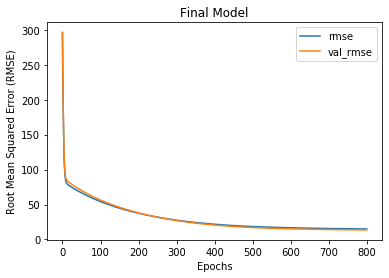

In [36]:
print(f"Final Model", end=f"\n{'-'*100}\n")
    
print("Final Training Results")
print(final_model["training_results"].iloc[-1, :4], end=f"\n{'-'*100}\n")

print("Final Validation Results")
print(final_model["training_results"].iloc[-1, 8:12], end=f"\n{'-'*100}\n")

print("Test Set Results")
print(final_model["error_metrics"].iloc[0], end=f"\n{'='*100}\n\n\n\n")

ax = final_model["training_results"].plot(
    y=["rmse", "val_rmse"], title=f"Final Model",
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Root Mean Squared Error (RMSE)")